# Exploratory Data Analysis

The work in this notebook focuses on standard flow of understanding and processing the dataset. The goal is to explore the features and their relationships. The desired output of this phase is a cleaned dataset ready for ML model training.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The OmniAnomaly dataset is originally intended for multivariate unsupervised analysis. That means, that if I want to use a supervised learning model like the Random Forest Classifier, the training data is useless for me and all i can use is the labeled test data. I did a quick initial analysis that showed, that their labeled testing dataset contains >28k rows with >2.5k anomaly instances. This is still enough for both training and testing my model, so instead of loking for a new dataset, I'll simply split the original testing data by 70/30 ratio for my training and testing purposes. 

In [22]:
# Load the Data
data = pd.read_csv('../data/machine-1-1.txt', header=None)
labels = pd.read_csv('../data/machine-1-1-label.txt', header=None)

# Rename Columns for Clarity
feature_names = [f"feat_{i}" for i in range(data.shape[1])]
data.columns = feature_names
labels.columns = ['label']

# Combine into one DataFrame
full_df = pd.concat([data, labels], axis=1)

# Split into Train and Test Sets
train_size = int(len(full_df) * 0.70)
train_df = full_df.iloc[:train_size].reset_index(drop=True)
test_df  = full_df.iloc[train_size:].reset_index(drop=True)

# Quick Verification
print(f"Total Rows: {len(full_df)}")
print(f"Train Rows: {len(train_df)} | Anomalies in Train: {train_df['label'].sum()}")
print(f"Test Rows:  {len(test_df)}  | Anomalies in Test:  {test_df['label'].sum()}")

Total Rows: 28479
Train Rows: 19935 | Anomalies in Train: 2125
Test Rows:  8544  | Anomalies in Test:  569


## Univariate analysis

First, I'll check if there are any missing values. Since this is an already processed dataset from the OmniAnomaly project, I assume there shouldn't be any, but just in case.

In [12]:
# Check for Missing Values
missing_values = train_df.isnull().sum().sum()

print(f"Total Missing Values in Training Data: {missing_values}")

Total Missing Values in Training Data: 0


No missing values - good. Next, I'll look at some basic descriptive statistics.

In [13]:
train_df.describe()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,label
count,19935.000000,19935.000000,19935.000000,19935.000000,19935.0,19935.000000,19935.000000,19935.0,19935.000000,19935.000000,...,19935.000000,19935.000000,19935.000000,19935.000000,19935.000000,19935.000000,19935.000000,19935.0,19935.0,19935.000000
mean,0.141158,0.108112,0.107501,0.106281,0.0,0.917373,0.250663,0.0,0.023567,0.001171,...,0.016802,0.097339,0.072008,0.001070,0.000937,0.106631,0.106676,0.0,0.0,0.106596
std,0.139622,0.106150,0.106329,0.108161,0.0,0.028951,0.081416,0.0,0.018159,0.017392,...,0.029541,0.095390,0.073146,0.023508,0.024205,0.105629,0.105622,0.0,0.0,0.308607
min,0.010753,0.001059,0.004459,0.008130,0.0,0.351282,0.005650,0.0,0.000000,0.000000,...,0.004298,0.010819,0.009264,0.000000,0.000011,0.015420,0.015492,0.0,0.0,0.000000
25%,0.064516,0.046610,0.049052,0.047619,0.0,0.900000,0.241996,0.0,0.013483,0.000000,...,0.008596,0.044997,0.034483,0.000000,0.000022,0.049048,0.049081,0.0,0.0,0.000000
50%,0.096774,0.078390,0.079153,0.077816,0.0,0.910256,0.269303,0.0,0.024127,0.000122,...,0.011461,0.074710,0.053011,0.000386,0.000034,0.078839,0.078905,0.0,0.0,0.000000
75%,0.150538,0.129237,0.118172,0.112660,0.0,0.925641,0.282486,0.0,0.031223,0.000244,...,0.018625,0.102470,0.074112,0.000386,0.000045,0.112358,0.112350,0.0,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000


The data seem to have been Min-Max scaled. There are multiple features that seem to have no other value then zero. The output is truncated, so there could be even more features like this.

In [23]:
zero_variance_cols_train = train_df.columns[(train_df == 0).all()]
zero_variance_cols_test = test_df.columns[(test_df == 0).all()]

print(zero_variance_cols_test)
print(zero_variance_cols_train)


Index(['feat_4', 'feat_7', 'feat_16', 'feat_17', 'feat_26', 'feat_36',
       'feat_37'],
      dtype='str')
Index(['feat_4', 'feat_7', 'feat_16', 'feat_17', 'feat_36', 'feat_37'], dtype='str')


There are 6 features that have no values in both test and train parts of the dataset. Feature 26 is interesting, because it has no values in the testing dataset, but seems to have some in the training dataset. I'll take a closer look at it.

In [24]:
# Check unique values and their counts for 'feat_26'
unique_values_feat26 = train_df['feat_26'].value_counts().sort_index()
print("\nUnique values and their counts for 'feat_26' (Train):")
display(unique_values_feat26)


Unique values and their counts for 'feat_26' (Train):


feat_26
0.000000    19913
0.058824        1
0.117647        3
0.176471        3
0.235294        2
0.470588        1
0.588235        1
0.647059        1
0.705882        3
0.764706        1
0.823529        4
0.882353        1
1.000000        1
Name: count, dtype: int64

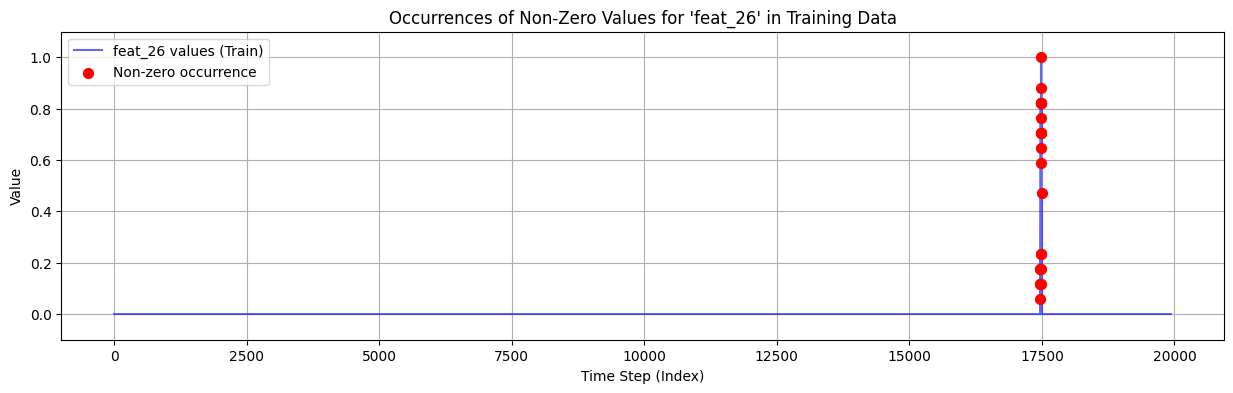

In [25]:
feat_26_series_train = train_df['feat_26']

# Identify indices where 'feat_26' is not zero
non_zero_indices_train = feat_26_series_train[feat_26_series_train != 0].index

plt.figure(figsize=(15, 4))
# Plot the entire series 
plt.plot(feat_26_series_train.index, feat_26_series_train.values, 
         alpha=0.6, label='feat_26 values (Train)', color='blue')

# Highlight the non-zero occurrences as distinct points
if len(non_zero_indices_train) > 0:
    plt.scatter(non_zero_indices_train, feat_26_series_train[non_zero_indices_train], 
                color='red', s=50, zorder=5, label='Non-zero occurrence')
    
plt.title("Occurrences of Non-Zero Values for 'feat_26' in Training Data")
plt.xlabel("Time Step (Index)")
plt.ylabel("Value")
plt.ylim(-0.1, 1.1) 
plt.grid(True)
plt.legend()
plt.show()

The fact that all the non-zero values of this feature are clustered together indicates, that some specific rare event could have happened at that time, or maybe a bug or configuration error happened and was quickly fixed. While this could potentially still be an important marker for anomalies in the real cloud environment, feat_26 will provide no information during the evaluation period of my model on this dataset, because it has no values in the testing data. Same goes for the other features, that have no non-zero values. Perhaps in real environment they could have their importance, but for the purposes of this project they have no meaning.

In [26]:
cols_to_drop = ["feat_4", "feat_7", "feat_16", "feat_17", "feat_26", "feat_36", "feat_37"]

train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

print(f"New Training Data Shape: {train_df.shape}")
print(f"New Test Data Shape:     {test_df.shape}")

New Training Data Shape: (19935, 32)
New Test Data Shape:     (8544, 32)


### Visualization


--- Histograms for all Features in Taining Data(Overview) ---


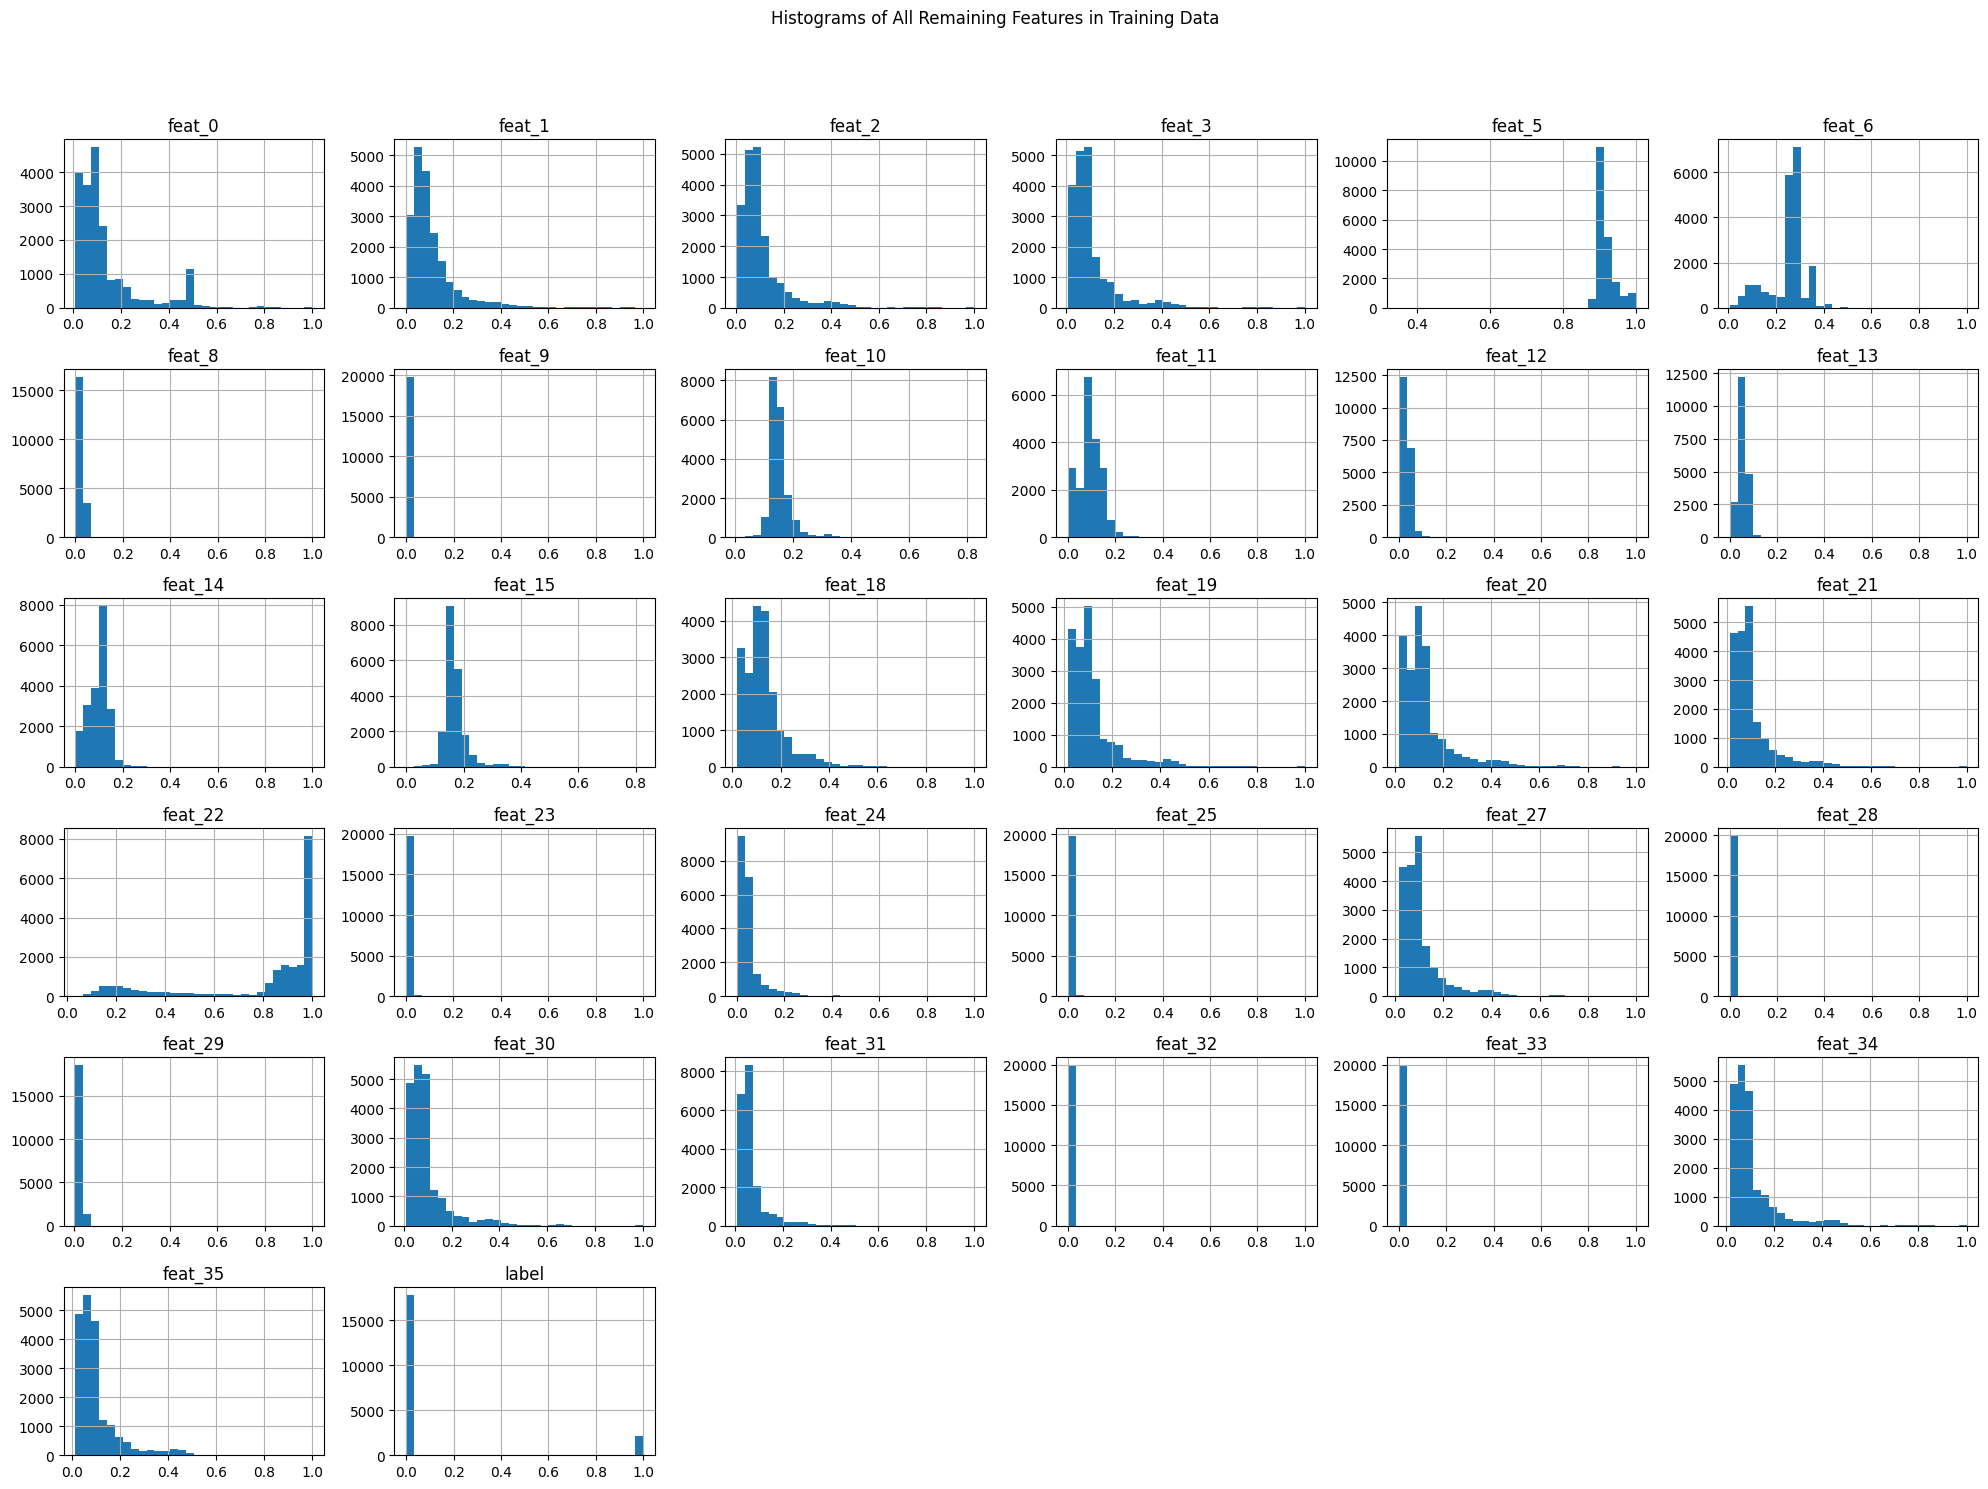

In [29]:
print("\n--- Histograms for all Features in Taining Data (Overview) ---")
train_df.hist(figsize=(20, 15), bins=30)
plt.suptitle("Histograms of All Remaining Features in Training Data", y=1.02) 
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


--- Histograms for all Features in Testing Data (Overview) ---


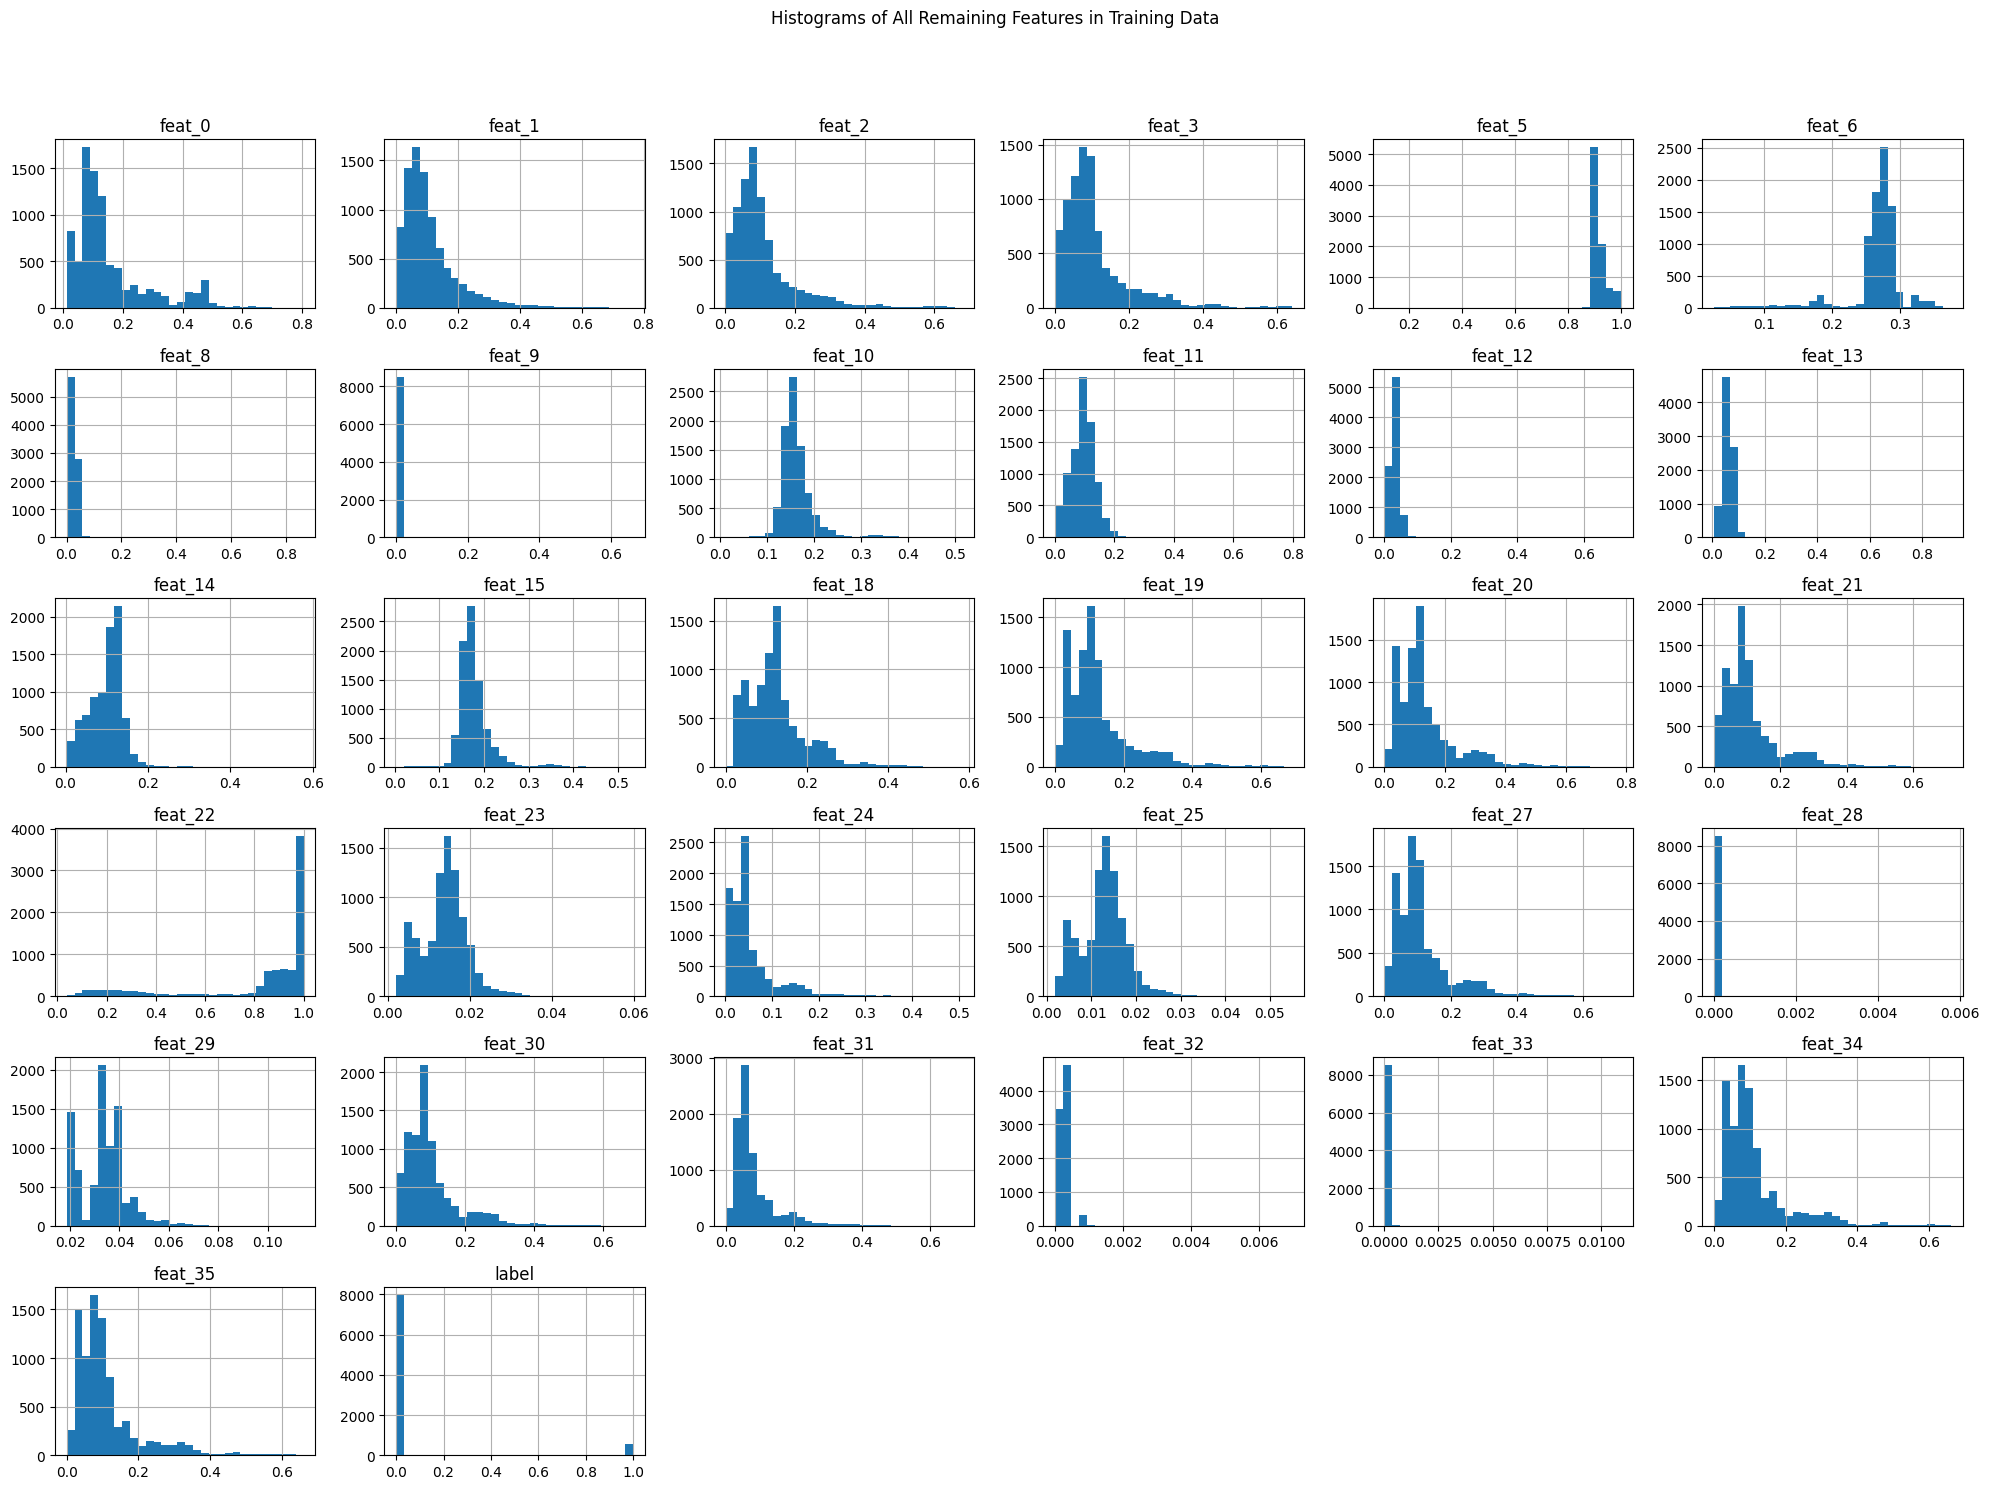

In [30]:
print("\n--- Histograms for all Features in Testing Data (Overview) ---")
test_df.hist(figsize=(20, 15), bins=30)
plt.suptitle("Histograms of All Remaining Features in Training Data", y=1.02) 
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

There still seem to be some features in both the training and testing data, that have mostly zero values and only a few non-zero instances. These however, cannot be dropped, because they have non-zero occurences in both training and testing data. They could represent some event-driven metrics that only gain values when a specific event occurs and therefore might be indicative of anomalies.

## Bivariate analysis

Next, I'll examine how each feature behaves in relation to the anomaly label. This should help identify potential early warning signals.


--- Grid Plots: All 31 Features vs. Anomaly Timeline ---
This will generate a large grid. Zoom in on the plots to inspect details.


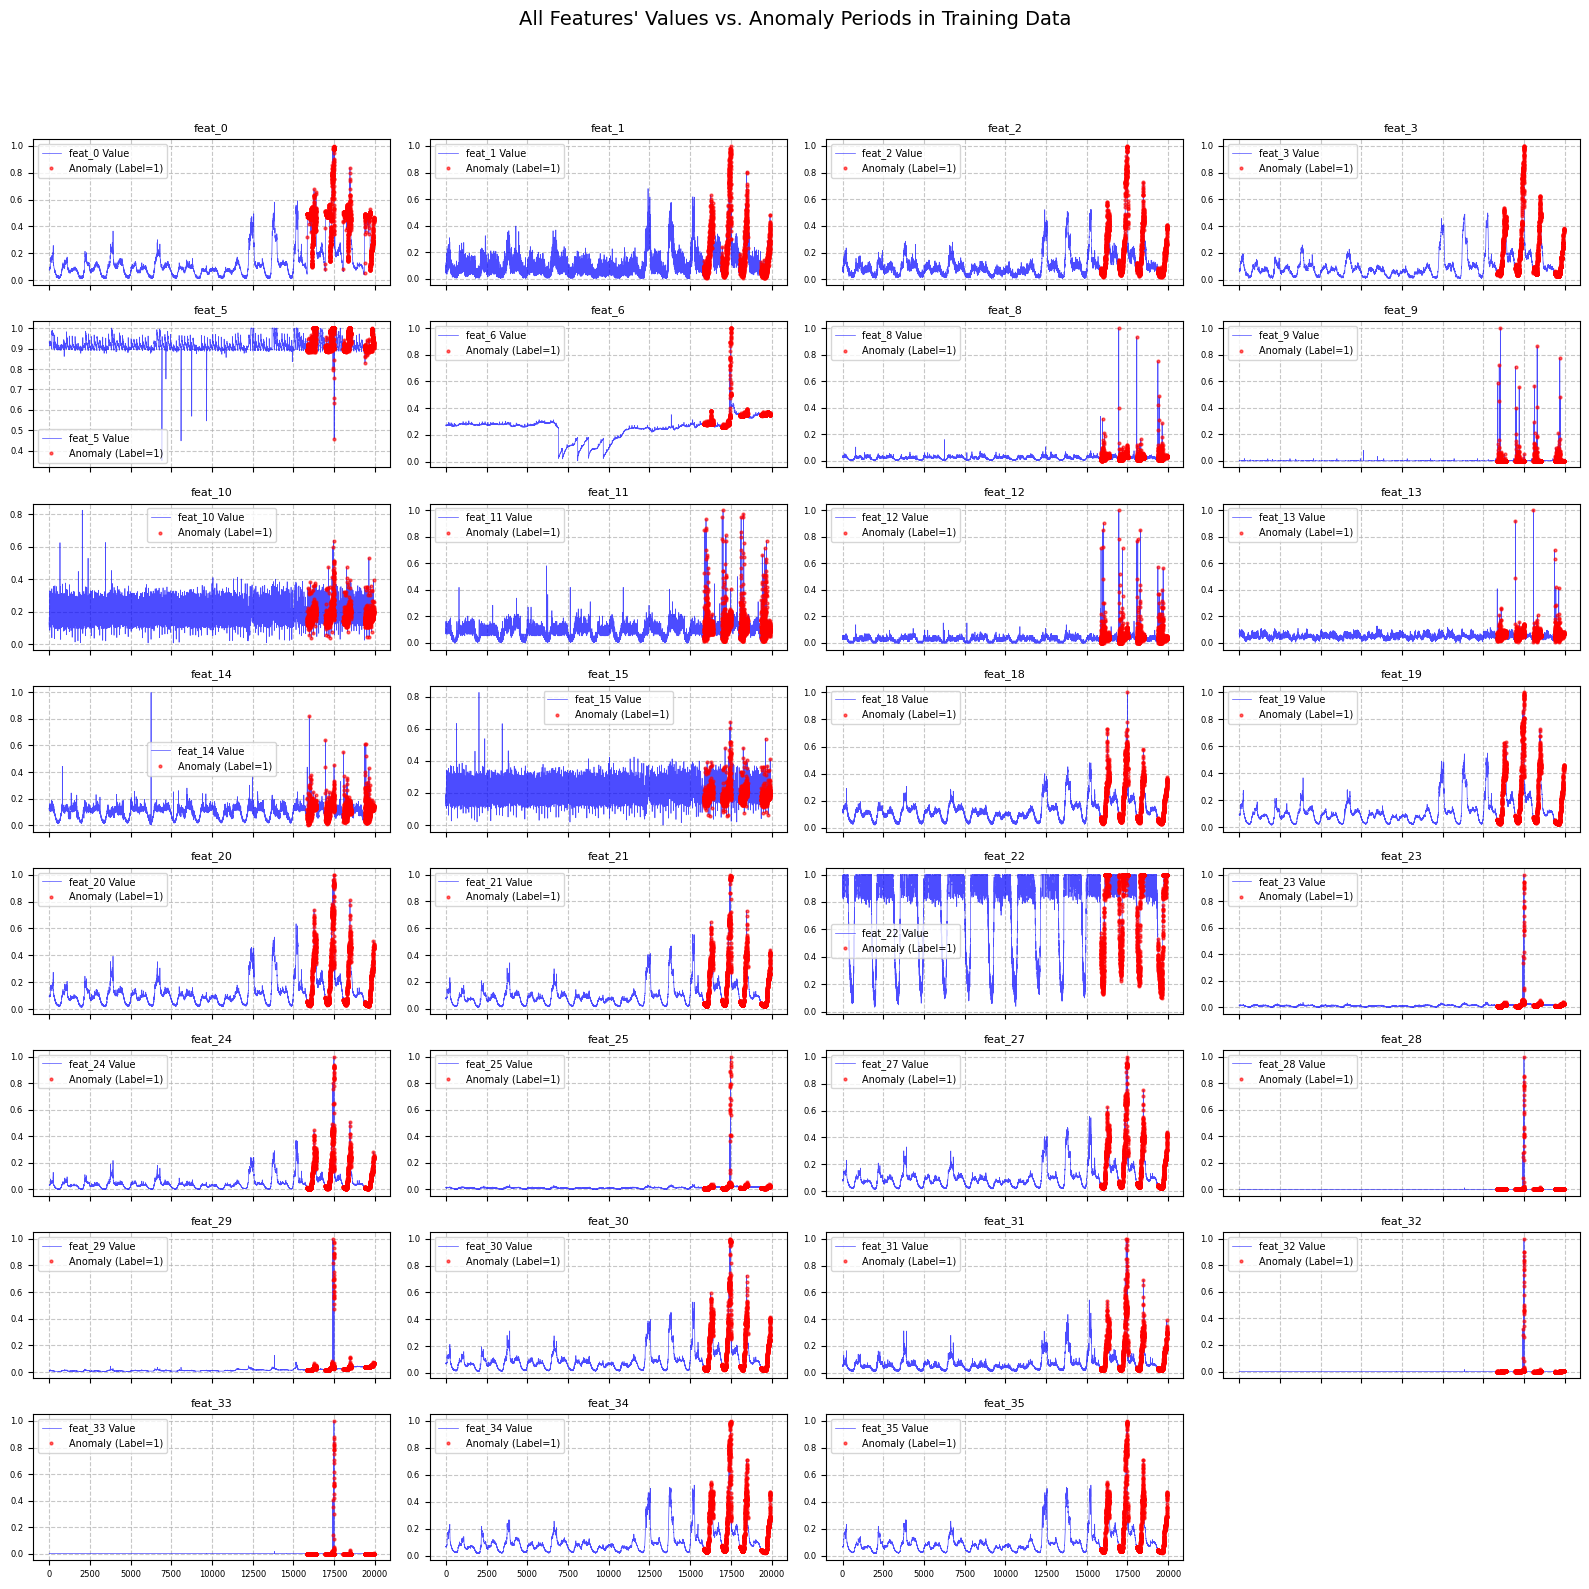

In [33]:
features_df = train_df.drop(columns=['label'], errors='ignore')
n_features = features_df.shape[1]
feature_names = features_df.columns.tolist()

# Grid of Time-Series Plots for all Features vs. Anomalies
print(f"\n--- Grid Plots: All {n_features} Features vs. Anomaly Timeline ---")

num_cols = 4 
num_rows = (n_features + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 2), sharex=True)
axes = axes.flatten() 

for i, feature in enumerate(feature_names):
    ax = axes[i]
    
    ax.plot(features_df.index, features_df[feature], label=f'{feature} Value', alpha=0.7, color='blue', linewidth=0.5)
    
    anomaly_occurrence_points = np.where(train_df['label'] == 1, features_df[feature], np.nan)
    ax.plot(features_df.index, anomaly_occurrence_points, 'o', color='red', markersize=2, label='Anomaly (Label=1)', alpha=0.6)
    
    ax.set_title(f'{feature}', fontsize=8)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("All Features' Values vs. Anomaly Periods in Training Data", y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.show()

The plots seem to support the previous assumption about event-driven indicators. Features, such as 33, 32, 29 and more, that have mostly zero values, seem to have strong correaltion with anomaly instances during their peaks, making them strong indicators for anomalies.

On the other hand, there are some features like 10, 15, 22 that appear mostly stable throughout the entire timeframe. While they do not show much coincidence with anomalies on their own, they are not necessarily irrelevant. They might still have some contextual relevance in combination with other features.